In [9]:
# Loading necessary modules.
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from os import fspath
%matplotlib inline
import seaborn as sns
import math
import pandas as pd

In [10]:
import MDAnalysis as mda
mda.__version__

'2.7.0'

In [11]:
import nglview

In [12]:
from MDAnalysis.analysis.align import AlignTraj
from MDAnalysis.analysis.rms import RMSD, RMSF
from MDAnalysis.analysis.pca import PCA, cosine_content

In [13]:
data_path = "../../data/01_raw/02_NPT/01_npt_1/"
proc_path = "../../data/02_processed/02_prod/"

sel = 'name CA'

config_file = data_path + "step5_production.gro"
rawtraj_file = data_path + "step5_production.xtc"
prctraj_file = proc_path + 'prod_1/prod_1_traj_aligned.xtc'
# already done
# rawtraj_file = data_path + "step5_production.xtc"
# prctraj_file = proc_path + 'prod_1/step5_production_aligned_lastframe.xtc'
# rec_traj = mda.Universe(config_file, rawtraj_file)
# rec_ref = mda.Universe(config_file, rawtraj_file)
# rec_ref.trajectory[-1]
# aligner = AlignTraj(rec_traj,rec_ref,select=sel,filename = prctraj_file)
# aligner.run()

config_12_file = proc_path + "prod_2_not_terminated/struct_1.tpr"
cattraj_file = proc_path + "prod_2_not_terminated/p_12_concat_al.xtc"
traj1_file = proc_path + 'prod_2_not_terminated/prod_1_nbc.xtc'
traj2_file = proc_path + 'prod_2_not_terminated/prod_2_nbc.xtc'
# already done
# rec_traj = mda.Universe(config_file, [traj1_file, traj2_file])
# rec_ref = mda.Universe(config_12_file, traj2_file)
# rec_ref.trajectory[-1]
# aligner = AlignTraj(rec_traj,rec_ref,select=sel,filename = cattraj_file)
# aligner.run()

In [14]:
rec_alignd = mda.Universe(config_file, prctraj_file)
rec_alignd_ref = mda.Universe(config_file, prctraj_file)
rec_alignd_ref.trajectory[-1]

cat_alignd = mda.Universe(config_12_file, cattraj_file)
cat_alignd_ref = mda.Universe(config_12_file, cattraj_file)
cat_alignd_ref.trajectory[-1]

< Timestep 361 with unit cell dimensions [71.02746 71.02746 71.02746 90.      90.      90.     ] >

In [15]:
print(f"frames of traj prod_1: {rec_alignd.trajectory.n_frames}")
print(f"frames of traj prod_1 concatted with traj prod_2: {cat_alignd.trajectory.n_frames}")

frames of traj prod_1: 241
frames of traj prod_1 concatted with traj prod_2: 362


In [34]:
view = nglview.show_mdanalysis(cat_alignd)
view

NGLWidget(max_frame=361)

In [17]:
R = RMSD(rec_alignd, rec_alignd_ref, select=sel).run()
Rcat = RMSD(cat_alignd, cat_alignd_ref, select=sel).run()

Text(0, 0.5, 'rmsd')

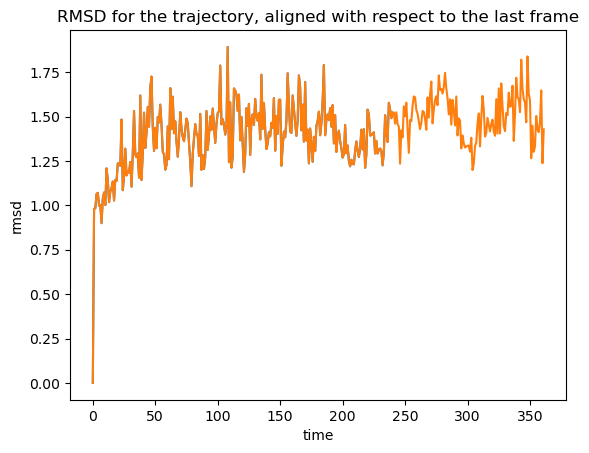

In [18]:
plt.title("RMSD for the trajectory, aligned with respect to the last frame")
plt.plot(R.results.rmsd[:, 0], R.results.rmsd[:, 2])
plt.plot(Rcat.results.rmsd[:, 0], Rcat.results.rmsd[:, 2])
plt.xlabel("time")
plt.ylabel("rmsd")

In [19]:
Rf = RMSF(rec_alignd.select_atoms(sel)).run()
Rfcat = RMSF(cat_alignd.select_atoms(sel)).run()

Text(0, 0.5, 'RMSF')

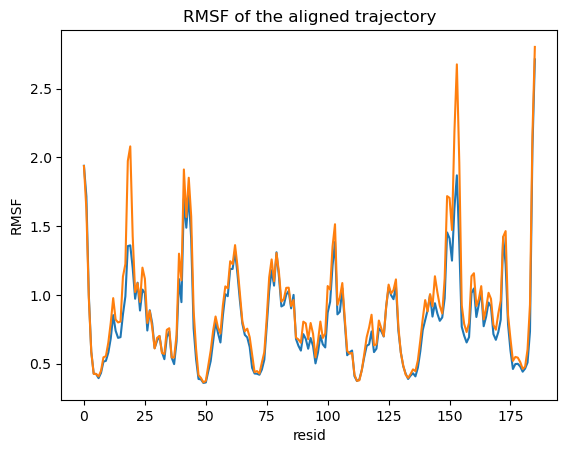

In [20]:
plt.title("RMSF of the aligned trajectory")
plt.plot(Rf.results.rmsf)
plt.plot(Rfcat.results.rmsf)
plt.xlabel("resid")
plt.ylabel("RMSF")

In [21]:
cat_pca = PCA(cat_alignd, select=sel)
cat_pca.run()

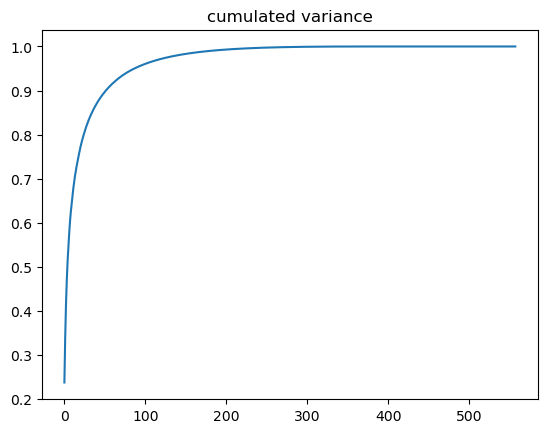

In [22]:
plt.title("cumulated variance")
plt.plot(cat_pca.results.cumulated_variance)

In [23]:
print(cat_pca.results.cumulated_variance[2])

0.41565177135659787


In [24]:
pca_space = cat_pca.transform(cat_alignd.select_atoms(sel), 2)

In [25]:
pca_data = pd.DataFrame(pca_space,columns=['first_comp','second_comp'])
pca_data["group"] = pca_data.index // 40
pca_data

,first_comp,second_comp,group
0,2.884780,-1.812513,0
1,8.295061,-2.786600,0
2,8.281236,-3.140362,0
3,10.013458,-0.551654,0
4,3.754858,-1.219822,0
...,...,...,...
357,13.056037,-0.661974,8
358,15.218113,-1.631988,8
359,18.060107,-1.785509,8
360,8.636086,0.762071,9


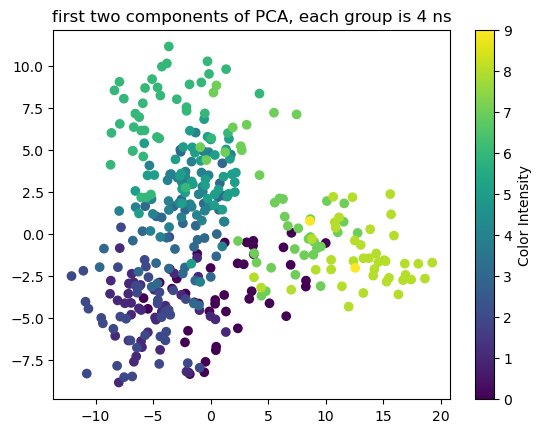

In [26]:
plt.title("first two components of PCA, each group is 4 ns")
scatter = plt.scatter(pca_data["first_comp"], pca_data["second_comp"], c= pca_data["group"])
plt.colorbar(scatter, label='Color Intensity')

In [27]:
pc1 = cat_pca.p_components[:, 0]
trans1 = pca_space[:, 0]
projected = np.outer(trans1, pc1) + cat_pca.mean.flatten()
coordinates = projected.reshape(len(trans1), -1, 3)

/home/giacomo/micromamba/envs/QCB/lib/python3.12/site-packages/MDAnalysis/analysis/pca.py:321: DeprecationWarning: The `p_components` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.p_components` instead.
  warnings.warn(wmsg, DeprecationWarning)


In [28]:
proj1 = mda.Merge(cat_alignd.select_atoms(sel))
proj1.load_new(coordinates, order="fac")

<Universe with 186 atoms>

In [29]:
cat_alignd.select_atoms("name CA").write("traj_pca.pdb")

/home/giacomo/micromamba/envs/QCB/lib/python3.12/site-packages/MDAnalysis/coordinates/PDB.py:1153: UserWarning: Found no information for attr: 'altLocs' Using default value of ' '
  warnings.warn("Found no information for attr: '{}'"
/home/giacomo/micromamba/envs/QCB/lib/python3.12/site-packages/MDAnalysis/coordinates/PDB.py:1153: UserWarning: Found no information for attr: 'icodes' Using default value of ' '
  warnings.warn("Found no information for attr: '{}'"
/home/giacomo/micromamba/envs/QCB/lib/python3.12/site-packages/MDAnalysis/coordinates/PDB.py:1153: UserWarning: Found no information for attr: 'occupancies' Using default value of '1.0'
  warnings.warn("Found no information for attr: '{}'"
/home/giacomo/micromamba/envs/QCB/lib/python3.12/site-packages/MDAnalysis/coordinates/PDB.py:1153: UserWarning: Found no information for attr: 'tempfactors' Using default value of '0.0'
  warnings.warn("Found no information for attr: '{}'"
/home/giacomo/micromamba/envs/QCB/lib/python3.12/site

In [33]:
view = nglview.show_mdanalysis(proj1)
view

NGLWidget(max_frame=361)

In [31]:
Rred = RMSF(proj1.select_atoms(sel)).run()

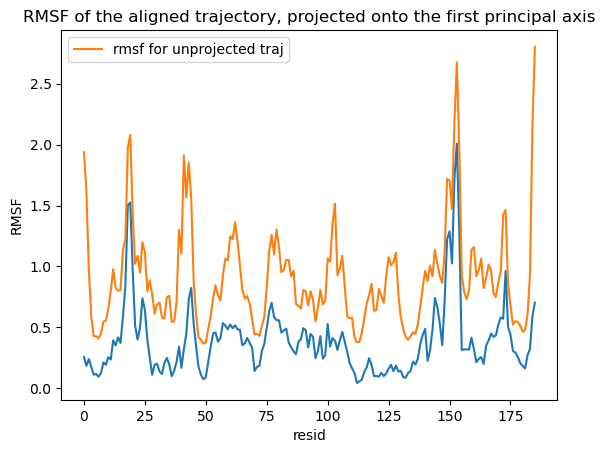

In [32]:
plt.title("RMSF of the aligned trajectory, projected onto the first principal axis")
plt.plot(Rred.results.rmsf)
plt.plot(Rfcat.results.rmsf, label = "rmsf for unprojected traj")
plt.xlabel("resid")
plt.ylabel("RMSF")
plt.legend()